In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import numpy as np
from scipy import interp
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl

from sklearn.ensemble import GradientBoostingClassifier as gboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (precision_recall_curve, average_precision_score, 
                             roc_curve, auc, confusion_matrix, mean_squared_error,
                             classification_report)
from sklearn import metrics
from sklearn.model_selection import cross_validate

from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, RepeatVector, Lambda
from keras.layers import Activation
from keras.optimizers import RMSprop, Adam
from keras.layers.merge import _Merge
from keras import backend as K
from functools import partial
from keras.metrics import binary_crossentropy
from keras.layers import BatchNormalization
from keras import regularizers


pd.options.display.max_rows = 4000

# In[0]: Functions Definitions

def scalex(X):
    """ normalize between 0 and 1 the values in X """
    nmin, nmax = 0.0, 1.0
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (nmax - nmin) + nmin
    return X_scaled
#
# Last card of scalex.
#
def calcrmse(X_train, gensamples):
    """ compute mse for training """
    max_column = X_train.shape[1]
    rmse_lst = []
    for col in range(max_column):
        rmse_lst.append(np.sqrt(mean_squared_error(X_train[:,col], gensamples[:,col])))
    return np.sum(rmse_lst) / max_column
#
# Last card of calcrmse.
#
def wasserstein_loss(y_true, y_pred):
    """ Wasserstein distance """
    return K.mean(y_true * y_pred)
#
# Last card of wasserstein_loss.
#
def gradient_penalty_loss(y_true, y_pred, averaged_samples, lamba_reg):
    """ compute gradient penalty loss for GP-WGAN """
    gradients = K.gradients(y_pred, averaged_samples)[0]
    gradients_sqr = K.square(gradients)
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    gradient_penalty = lamba_reg * K.square(1 - gradient_l2_norm)
    return K.mean(gradient_penalty)
#
# Last card of gradient_penalty_loss.
#
class RandomWeightedAverage(_Merge):
    def _merge_function(self, inputs):
        weights = K.random_uniform((BATCH_SIZE, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])
#
# Last card of RandomWeightedAverage.
#
def generate_samples(generator_model, noise_dim, num_samples):
    """ generate samples to be used for futher analysis """
    return generator_model.predict(np.random.rand(num_samples, noise_dim))
#
# Last card of generate_samples.
#
# Last card of generate_images2D.
#
#
# Last card of writetocsv.

Using TensorFlow backend.
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)

In [2]:
df = pd.read_csv('./data/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv', sep=",", header=None, low_memory=False)
print(df)

                       0               1                   2   \
0        Destination Port   Flow Duration   Total Fwd Packets   
1                      80           38308                   1   
2                     389             479                  11   
3                      88            1095                  10   
4                     389           15206                  17   
...                   ...             ...                 ...   
692699                 53           32215                   4   
692700                 53             324                   2   
692701              58030              82                   2   
692702                 53         1048635                   6   
692703                 53           94939                   4   

                             3                            4   \
0        Total Backward Packets  Total Length of Fwd Packets   
1                             1                            6   
2                          

In [3]:
df = df.dropna()

In [4]:
df.columns = df.iloc[0]
df = df[1:]

In [5]:
df = df.apply(pd.to_numeric, errors='ignore')
print(df.dtypes)

0
 Destination Port                 int64
 Flow Duration                    int64
 Total Fwd Packets                int64
 Total Backward Packets           int64
Total Length of Fwd Packets       int64
 Total Length of Bwd Packets      int64
 Fwd Packet Length Max            int64
 Fwd Packet Length Min            int64
 Fwd Packet Length Mean         float64
 Fwd Packet Length Std          float64
Bwd Packet Length Max             int64
 Bwd Packet Length Min            int64
 Bwd Packet Length Mean         float64
 Bwd Packet Length Std          float64
Flow Bytes/s                    float64
 Flow Packets/s                 float64
 Flow IAT Mean                  float64
 Flow IAT Std                   float64
 Flow IAT Max                     int64
 Flow IAT Min                     int64
Fwd IAT Total                     int64
 Fwd IAT Mean                   float64
 Fwd IAT Std                    float64
 Fwd IAT Max                      int64
 Fwd IAT Min                      int6

In [6]:
print(df.columns)

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [7]:
def kill_empty_first(df):
    for column in df.columns:
        unique_values = np.unique(df[column])
        if len(unique_values) > 1:
            print(f"Column '{column}' has different values.")
        else:
            print(f"Column '{column}' has the same value in all rows.")
            df.drop(column, axis=1, inplace=True)

#kill_empty_first(df)

In [8]:
label_counts = df[' Label'].value_counts()
print(label_counts)

BENIGN              439972
DoS Hulk            230124
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name:  Label, dtype: int64


In [9]:
print(df.columns)

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [10]:
print(len(df.columns))

79


In [11]:
lbl = df.columns

In [12]:
print(df.isna().sum())

0
 Destination Port               0
 Flow Duration                  0
 Total Fwd Packets              0
 Total Backward Packets         0
Total Length of Fwd Packets     0
 Total Length of Bwd Packets    0
 Fwd Packet Length Max          0
 Fwd Packet Length Min          0
 Fwd Packet Length Mean         0
 Fwd Packet Length Std          0
Bwd Packet Length Max           0
 Bwd Packet Length Min          0
 Bwd Packet Length Mean         0
 Bwd Packet Length Std          0
Flow Bytes/s                    0
 Flow Packets/s                 0
 Flow IAT Mean                  0
 Flow IAT Std                   0
 Flow IAT Max                   0
 Flow IAT Min                   0
Fwd IAT Total                   0
 Fwd IAT Mean                   0
 Fwd IAT Std                    0
 Fwd IAT Max                    0
 Fwd IAT Min                    0
Bwd IAT Total                   0
 Bwd IAT Mean                   0
 Bwd IAT Std                    0
 Bwd IAT Max                    0
 Bwd IAT Min

In [13]:
warnings.filterwarnings("ignore", category=DeprecationWarning)


#def create_normalized_dataframe(df, attack_name):
#    df_new = df.loc[df[" Label"] == attack_name]

#   # normalize each field independently
#    df_attack_norm = df_new
#    for n in range(len(lbl)-1):
#        m = lbl[n] 
#        if (len(np.unique(df_attack_norm[m])) > 1):
#            df_attack_norm[m] = scalex(df_attack_norm[m])
#        else:
#            df_attack_norm[m] = np.int64(1)

#    return df_attack_norm

def create_normalized_dataframe(df, attack_name):
    df_new = df.loc[df[" Label"] == attack_name]

    features = []
    for n in range(len(lbl)-1):
        m = lbl[n]
        tmp = np.unique(df_new[m])
        if (len(tmp) > 1):
            features.append(m)

    # normalize each field independently
    df_attack_norm = df_new
    for n in range(len(lbl)-1):
        m = lbl[n]
        if (np.max(df_attack_norm[m]) > 1).any(): 
            if (len(np.unique(df_attack_norm[m])) > 1):
                df_attack_norm[m] = scalex(df_attack_norm[m])
            else:
                df_attack_norm[m] = np.int64(1)  

    return df_attack_norm

def kill_empty(df):
    for column in df.columns[:-1]:
        unique_values = np.unique(df[column])
        if len(unique_values) > 1:
            print(f"Column '{column}' has different values.")
        else:
            print(f"Column '{column}' has the same value in all rows.")
            df.drop(column, axis=1, inplace=True)

    return df


#attack_name = "DoS slowloris"
#attack_name = "DoS Hulk"
#attack_name = "SSH-Patator"
attack_name = "DoS GoldenEye"
df_attack_norm = create_normalized_dataframe(df, attack_name)
#df_normal_norm = create_normalized_dataframe(df, "BENIGN")
#df_attack_norm = kill_empty(df_attack_norm)
print(df_attack_norm)


# In[3]: build GP-WGAN and generate adversarial samples
#
BATCH_SIZE = 2048

GRADIENT_PENALTY_WEIGHT = 10 #0.1
MAX_SIM = 10293 #10000
X_train = np.asarray(df_attack_norm.iloc[:MAX_SIM, :-1])
np.random.shuffle(X_train)
#df_attack_norm.to_csv('output.csv', index=False)
#
MAX_EPOCH = 15000 #15000
TRAINING_RATIO = 3
#
NUM_SAMPLES = 2000 #5000
#
### Building the model
def make_generator(noise_dim):
    model = Sequential()
    model.add(Dense(256,  kernel_initializer='he_normal', input_dim=INPUT_DIM))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(128,  kernel_initializer='he_normal'))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(128,  kernel_initializer='he_normal'))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(128,  kernel_initializer='he_normal'))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(units=noise_dim, activation='linear'))
    return model
#
#    Last card of make_generator.
#    
def make_discriminator():
    model = Sequential()
    model.add(Dense(256, kernel_initializer='he_normal', input_dim=INPUT_DIM))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(128, kernel_initializer='he_normal', input_dim=INPUT_DIM))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(128, kernel_initializer='he_normal', input_dim=INPUT_DIM))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(128, kernel_initializer='he_normal', input_dim=INPUT_DIM))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(units=1, activation='linear'))
    return model
#
#    Last card of make_discriminator.
#
print("current_gradpenalty:", GRADIENT_PENALTY_WEIGHT)

INPUT_DIM = X_train.shape[1]
noise_dim = INPUT_DIM

generator = make_generator(noise_dim)
discriminator = make_discriminator()


#### for the generator it is mostly the same as WGAN std
for layer in discriminator.layers:
    layer.trainable = False
discriminator.trainable = False

generator_input = Input(shape=(noise_dim,))
generator_layers = generator(generator_input)
discriminator_layers_for_generator = discriminator(generator_layers)

generator_model = Model(inputs=[generator_input], outputs=[discriminator_layers_for_generator])
generator_model.compile(optimizer=RMSprop(lr = 0.005, rho = 0.9, epsilon=1e-6), loss = wasserstein_loss)
#enerator_model.compile(optimizer=Adam(lr=0.0001, beta_1=0.5, beta_2=0.9), loss=wasserstein_loss)


#### New discriminator model for GPWGAN
for layer in discriminator.layers:
    layer.trainable = True
for layer in generator.layers:
    layer.trainable = False
discriminator.trainable = True
generator.trainable = False 


real_samples = Input(shape=X_train.shape[1:])
generator_input_for_discriminator = Input(shape=(noise_dim,))
generated_samples_for_discriminator = generator(generator_input_for_discriminator)
discriminator_output_from_generator = discriminator(generated_samples_for_discriminator)
discriminator_output_from_real_samples = discriminator(real_samples)

averaged_samples = RandomWeightedAverage()([real_samples, generated_samples_for_discriminator])
averaged_samples_out = discriminator(averaged_samples)

discriminator_model = Model(inputs=[real_samples, generator_input_for_discriminator], 
                            outputs=[discriminator_output_from_real_samples, discriminator_output_from_generator, 
                                     averaged_samples_out])


### the loss function takes more inputs than the standard y_true and y_pred 
### values usually required for a loss function. Therefore, we will make it partial.
partial_gp_loss = partial(gradient_penalty_loss, averaged_samples=averaged_samples, lamba_reg=GRADIENT_PENALTY_WEIGHT)
partial_gp_loss.__name__ = 'gp_loss' 


# finally, we compile the model
#discriminator_model.compile(optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-6), loss=wasserstein_loss)
discriminator_model.compile(optimizer=RMSprop(lr=0.005, rho=0.9, epsilon=1e-6), loss=[wasserstein_loss, wasserstein_loss, partial_gp_loss])
#discriminator_model.compile(optimizer=Adam(lr=0.0001, beta_1=0.5, beta_2=0.9), loss=wasserstein_loss)



positive_y = np.ones((BATCH_SIZE, 1), dtype=np.float32)
negative_y = -positive_y
dummy_y = np.zeros((BATCH_SIZE, 1), dtype=np.float32) # dummy vector mandatory for the train on batch function

for epoch in range(MAX_EPOCH + 1):
    np.random.shuffle(X_train)

    minibatches_size = BATCH_SIZE * TRAINING_RATIO
    for i in range(int(X_train.shape[0] // (BATCH_SIZE * TRAINING_RATIO))):
        discriminator_minibatches = X_train[i * minibatches_size:(i + 1) * minibatches_size]
        for j in range(TRAINING_RATIO):
            sample_batch = discriminator_minibatches[j * BATCH_SIZE:(j + 1) * BATCH_SIZE]
            noise = np.random.rand(BATCH_SIZE, noise_dim).astype(np.float32)

            discriminator_model.train_on_batch([sample_batch, noise], [positive_y, negative_y, dummy_y])

        generator_model.train_on_batch(np.random.rand(BATCH_SIZE, noise_dim), positive_y)


    #Visualization of intermediate results
    if (epoch % 100 == 0):
        gensamples = generate_samples(generator, noise_dim, MAX_SIM)
        rmse_sofar = calcrmse(X_train, gensamples)
        print("Epoch: ", epoch, "\t", "rmse: ", rmse_sofar)

    #if (epoch % 1000 == 0):
        #try:
            #gensamples = generate_samples(generator, noise_dim, MAX_SIM)
            #rmse_sofar = calcrmse(X_train, gensamples)
            #print("Epoch: ", epoch, "\t", "rmse: ", rmse_sofar)
            #print(gensamples)
        #except ValueError:
            #print("ValueError encountered. Skipping this iteration.")
            #continue

c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0        Destination Port   Flow Duration   Total Fwd Packets  \
331034                  1        0.041863            0.105263   
331035                  1        0.041857            0.263158   
331036                  1        0.041830            0.263158   
331037                  1        0.041828            0.263158   
331038                  1        0.041836            0.315789   
...                   ...             ...                 ...   
692607                  1        0.096223            0.315789   
692614                  1        0.096233            0.157895   
692653                  1        0.096198            0.263158   
692682                  1        0.096197            0.315789   
692697                  1        0.096223            0.157895   

0        Total Backward Packets  Total Length of Fwd Packets  \
331034                 0.555556                     0.049349   
331035                 0.555556                     0.060347   
331036                 0.66

KeyboardInterrupt: 

In [14]:
gensamples=generate_samples(generator, noise_dim, MAX_SIM)

df_gensamples = pd.DataFrame(gensamples)

df_original = df_attack_norm.iloc[:MAX_SIM, :-1]

df_gensamples.columns = df_original.columns

print(df_gensamples)

unique_samples = np.unique(df_gensamples, axis=0)
print(f"Number of unique samples: {len(unique_samples)}")

0       Destination Port   Flow Duration   Total Fwd Packets  \
0               1.038336        0.111644            0.175133   
1               0.998477        0.087157            0.289417   
2               0.999518        0.080470            0.176915   
3               1.087286        0.170236            0.211336   
4               1.046734        0.636132            0.012202   
...                  ...             ...                 ...   
10288           1.040626        0.085831            0.005485   
10289           1.028781        0.283523            0.013972   
10290           1.062913        0.193318            0.231477   
10291           0.993709        0.075475            0.309130   
10292           1.088641        0.896222            0.079937   

0       Total Backward Packets  Total Length of Fwd Packets  \
0                     0.500958                     0.029176   
1                     0.610562                     0.060721   
2                     0.508448            

In [15]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Get the column names of df_gensamples and df_original
column_names = df_gensamples.columns
count = 0

# Calculate RMSE for each column
rmse_values = []
for column in column_names:
    rmse = np.sqrt(mean_squared_error(df_gensamples[column], df_original[column]))
    rmse_values.append(rmse)

# Print the RMSE values
for column, rmse in zip(column_names, rmse_values):
    print(f"RMSE for column '{column}': {rmse}")
    if rmse > 0.30:
        count += 1

print(count)

RMSE for column ' Destination Port': 0.04084901932677971
RMSE for column ' Flow Duration': 0.31908011508105866
RMSE for column ' Total Fwd Packets': 0.22282794221505875
RMSE for column ' Total Backward Packets': 0.3764888490028458
RMSE for column 'Total Length of Fwd Packets': 0.10340246301445326
RMSE for column ' Total Length of Bwd Packets': 0.6133588475779312
RMSE for column ' Fwd Packet Length Max': 0.3464242824159894
RMSE for column ' Fwd Packet Length Min': 0.020592411620368505
RMSE for column ' Fwd Packet Length Mean': 0.19158354480216488
RMSE for column ' Fwd Packet Length Std': 0.2436654809869795
RMSE for column 'Bwd Packet Length Max': 0.4164706418748703
RMSE for column ' Bwd Packet Length Min': 0.2947389242968839
RMSE for column ' Bwd Packet Length Mean': 0.35363288587475133
RMSE for column ' Bwd Packet Length Std': 0.342289645483535
RMSE for column 'Flow Bytes/s': 0.242211217006627
RMSE for column ' Flow Packets/s': 0.04653936985252947
RMSE for column ' Flow IAT Mean': 0.30

In [16]:
#import numpy as np

# Calculate RMSE for each column
rmse_values = []
for column in df_original.columns:
    rmse = np.sqrt(mean_squared_error(df_original[column], df_gensamples[column]))
    rmse_values.append(rmse)

# Remove columns with RMSE > 0.3
columns_to_remove = [column for column, rmse in zip(df_gensamples.columns, rmse_values) if rmse > 0.3]
df_filtered_generated = df_gensamples.drop(columns_to_remove, axis=1)
df_filtered_original = df_original.drop(columns_to_remove, axis=1)

rmse_values_after = []
for column in df_filtered_original.columns:
    rmse = np.sqrt(mean_squared_error(df_filtered_original[column], df_filtered_generated[column]))
    rmse_values_after.append(rmse)
# Calculate average RMSE
average_rmse = np.mean(rmse_values)
print(f"Average RMSE: {average_rmse}")

average_after_rmse = np.mean(rmse_values_after)
print(f"Average RMSE after filtering: {average_after_rmse}")

Average RMSE: 0.2248509851023976
Average RMSE after filtering: 0.10048027489382076


Cleaning up the generated data- 

Fwd Packet length min - round to 0

SYN Flag - round to 0

Down/Up ratio - round to 1

min_seg_size_forward - round to 0.5

Fwd PSH Flags - round to 0

In [19]:
print(attack_name)

DoS GoldenEye


DoS GoldenEye
Column ' Destination Port' has different values.
Column ' Total Fwd Packets' has different values.
Column 'Total Length of Fwd Packets' has different values.
Column ' Fwd Packet Length Min' has different values.
Column ' Fwd Packet Length Mean' has different values.
Column ' Fwd Packet Length Std' has different values.
Column ' Bwd Packet Length Min' has different values.
Column 'Flow Bytes/s' has different values.
Column ' Flow Packets/s' has different values.
Column ' Flow IAT Std' has different values.
Column ' Flow IAT Min' has different values.
Column ' Fwd IAT Std' has different values.
Column 'Bwd IAT Total' has different values.
Column ' Bwd IAT Mean' has different values.
Column ' Bwd IAT Std' has different values.
Column ' Bwd IAT Max' has different values.
Column ' Bwd IAT Min' has different values.
Column 'Fwd PSH Flags' has different values.
Column ' Bwd PSH Flags' has different values.
Column ' Fwd URG Flags' has different values.
Column ' Bwd URG Flags' has

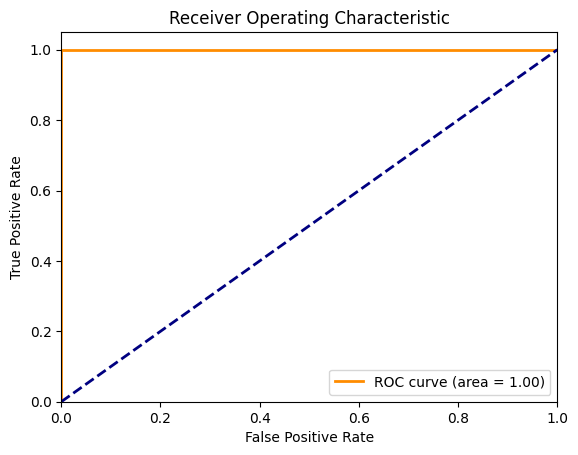

In [50]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

df_gensamples = df_filtered_generated
df_original = df_filtered_original

df_gensamples[' Label'] = 'generated'
df_original[' Label'] = 'normal'

if attack_name == "SSH-Patator":
    print("SSH-Patator")
    df_gensamples[' Fwd Packet Length Min'] = df_gensamples[' Fwd Packet Length Min'].round(0)
    df_gensamples[' SYN Flag Count'] = df_gensamples[' SYN Flag Count'].round(0)
    df_gensamples[' Down/Up Ratio'] = df_gensamples[' Down/Up Ratio'].round(1)
    df_gensamples[' min_seg_size_forward'] = (df_gensamples[' min_seg_size_forward'] * 2).round() / 2
    df_gensamples['Fwd PSH Flags'] = df_gensamples['Fwd PSH Flags'].round(0)
    df_gensamples.iloc[:, :-1] = df_gensamples.iloc[:, :-1].clip(lower=0)
    #df_gensamples[' Init_Win_bytes_backward'] = 0.892086330935251

    # Replace all non-zero values in column 'column_name' with 'new_value'
    #df_gensamples.loc[df_gensamples['Total Length of Fwd Packets'] != 0, 'Total Length of Fwd Packets'] = 0.524008350730689

    #df_gensamples.loc[df_gensamples[' Total Length of Bwd Packets'] != 0, ' Total Length of Bwd Packets'] = 0.483870967741935

    #df_gensamples.loc[df_gensamples[' Fwd Packet Length Max'] != 0, ' Fwd Packet Length Max'] = 0.446927374301675

    #df_gensamples.loc[df_gensamples[' Subflow Bwd Bytes'] != 0, ' Subflow Bwd Bytes'] = 0.483870967741935

    #df_gensamples.loc[df_gensamples[' Subflow Fwd Bytes'] != 0, ' Subflow Fwd Bytes'] = 0.524008350730689
elif attack_name == "DoS GoldenEye":
    print("DoS GoldenEye")
    df_gensamples.iloc[:, :-1] = df_gensamples.iloc[:, :-1].clip(lower=0)
    df_gensamples[' Bwd Packet Length Min'] = df_gensamples[' Bwd Packet Length Min'].round(0)
    df_gensamples[' URG Flag Count'] = df_gensamples[' URG Flag Count'].round(0)
    

else:
    print("NotPatator")

df_gensamples = kill_empty(df_gensamples)
df_original = kill_empty(df_original)

# Assuming df1 and df2 are your two dataframes

# Find the difference in columns
diff_columns = df_gensamples.columns.difference(df_original.columns)

# Drop the extra columns from df1
df_gensamples = df_gensamples.drop(columns=diff_columns)


# Now df1 and df2 have the same columns


df_gensamples.to_csv('filtered_generated_rounded.csv', index=False)
df_original.to_csv('filtered_original.csv', index=False)


# Assuming the columns to drop are 'column1' and 'column2'

#def convertstringtonumber(dfa, lst):
#    """ convert string to number """
#    for n in range(len(lst)):
#        dfa = dfa.replace(lst[n], n)
#    return dfa
NUM_SAMPLES = 5000 #5000
# aggregate generated data with true data
df_aggregated = pd.concat([df_original[:NUM_SAMPLES], df_gensamples[:NUM_SAMPLES]])
df_aggregated = df_aggregated.sample(frac=1)

df_aggregated.to_csv('aggregated.csv', index=False)

# separate the data set into train and test data sets
y = df_aggregated.iloc[:,-1]

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(df_aggregated.iloc[:,:-1], \
                                                    y, test_size=.2, random_state=42)

# Create an instance of the GradientBoostingClassifier
classifier = gboost(random_state=10, loss='deviance', learning_rate=0.05, 
                    n_estimators=200, criterion='friedman_mse', max_depth=3)

# Fit the classifier on the training data
classifier.fit(X_train, y_train)

# Use the classifier to predict the labels for the test data
y_pred = classifier.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Print the accuracy score
acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

# Print the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC: ", roc_auc)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [51]:
# Get feature importances
importances = classifier.feature_importances_

# Convert the importances into a DataFrame
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Sort the DataFrame to see the most important features at the top
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances)

                        feature    importance
16                Fwd Packets/s  6.872185e-01
12                  Bwd IAT Std  2.226474e-01
6                Flow Packets/s  3.013107e-02
25                  Active Mean  2.820174e-02
24         min_seg_size_forward  1.206577e-02
28                   Active Min  8.815844e-03
23             act_data_pkt_fwd  7.648905e-03
14                  Bwd IAT Min  1.130592e-03
17                Bwd Packets/s  9.845053e-04
0             Total Fwd Packets  3.126208e-04
1   Total Length of Fwd Packets  1.854970e-04
8                  Flow IAT Min  1.726526e-04
7                  Flow IAT Std  1.560501e-04
26                   Active Std  1.082216e-04
11                 Bwd IAT Mean  8.943173e-05
27                   Active Max  5.528923e-05
10                Bwd IAT Total  2.579518e-05
29                     Idle Std  1.958379e-05
9                   Fwd IAT Std  9.511964e-06
13                  Bwd IAT Max  6.718334e-06
22            Subflow Fwd Bytes  6